In [1]:
#Importando libs
from art.attacks.extraction import CopycatCNN, KnockoffNets
from art.estimators.classification import KerasClassifier
import numpy as np
from glob import glob
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm
import pandas as pd
import cv2
from PIL import Image
from statistics import mode
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics, model_selection
from keras.models import Sequential, load_model
import seaborn as sns
import pickle
from sklearn.metrics import roc_auc_score

c:\Users\jandr\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\jandr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_masked\__init__.py:223: UserWarning: Failed to initialize NumPy: module compiled against API version 0xf but this version of numpy is 0xe (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  example_input = torch.tensor([[-3, -2, -1], [0, 1, 2]])


In [2]:
googl = False

try:
    from google.colab import drive
    drive.mount('/content/drive')
    googl = True
except:
    googl = False

In [3]:
if googl:
    infile = open('/content/drive/MyDrive/Lab7sds/dataframe_p3.pkl','rb')
    df = pickle.load(infile)
    infile.close()
else:
    infile = open('dataframe_p3.pkl','rb')
    df = pickle.load(infile)
    infile.close()


Separando Data

In [4]:
target = df['Label_arrays'].to_numpy()
feature_matrix = df['Image'].to_numpy()

print(type(target))
print(type(feature_matrix))

#print('Final features:', feature_matrix.columns)

#División de datos de entrenamientos y prueba
X_train, X_score, y_train, y_score = model_selection.train_test_split(feature_matrix/255, 
                                                                      target, 
                                                                      test_size=0.30, 
                                                                      random_state=31)

X_train.shape

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


(2387,)

In [5]:
#Recasting

X_train = np.array(X_train.tolist(), dtype=float)
X_score = np.array(X_score.tolist(), dtype=float)
y_train = np.array(y_train.tolist(), dtype=float)
y_score = np.array(y_score.tolist(), dtype=float)

'''#Expandiendo dims
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_score, axis=2)'''

print(X_train.shape, type(X_train))

(2387, 128, 128, 3) <class 'numpy.ndarray'>


In [6]:
#Corrigiendo dims
print(y_train.shape)
print(X_train.shape)
print(X_score.shape)
print(y_score.shape)
num_classes=y_train.shape
number_pix=X_train.shape[1]*X_train.shape[2]
print(num_classes)
print(number_pix)

(2387, 23)
(2387, 128, 128, 3)
(1024, 128, 128, 3)
(1024, 23)
(2387, 23)
16384


Cargando Modelo

In [7]:
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

if googl:
    old_model = load_model('/content/drive/MyDrive/Lab7sds/benign_model.h5')
else:
    old_model = load_model('benign_model.h5')

In [8]:
print(old_model.evaluate(X_score, y_score))

c:\Users\jandr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[0.38619358465075493, 0.92578125]


Ataque de evasión

In [9]:
from art.attacks.evasion import FastGradientMethod

In [10]:
classifier = KerasClassifier(old_model, clip_values=(0, 1), use_logits=False)

In [11]:
# Craft adversarial samples with FGSM
epsilon = 0.1  # Maximum perturbation
adv_crafter = FastGradientMethod(classifier, eps=epsilon)
x_test_adv = adv_crafter.generate(x=X_score)

c:\Users\jandr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [12]:
# Evaluate the classifier on the adversarial examples
preds = np.argmax(classifier.predict(x_test_adv), axis=1)
acc = np.sum(preds == np.argmax(y_score, axis=1)) / y_score.shape[0]
print("\nTest accuracy on adversarial sample: %.2f%%" % (acc * 100))


Test accuracy on adversarial sample: 9.08%


Entrenando nuevo modelo robusto

In [13]:
#New robust model
robust_model = Sequential()

#Input Layer
robust_model.add(layers.Conv2D(128, (1, 1), activation='relu', input_shape=(128, 128, 3)))
robust_model.add(layers.MaxPooling2D((1, 1)))

#Layer 2
robust_model.add(layers.Conv2D(64, (1, 1), activation='relu'))
robust_model.add(layers.MaxPooling2D((1, 1)))


#Layer 3
robust_model.add(layers.Conv2D(64, (1, 1), activation='relu'))
robust_model.add(layers.Flatten())

#Final layer
robust_model.add(layers.Dense(64, activation='relu'))
robust_model.add(layers.Dense(23, activation='sigmoid'))

In [14]:
robust_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     512       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      4160      
                                                                 
 flatten (Flatten)           (None, 1048576)           0

In [15]:
robust_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
#Creando data de ruido
epsilon = 0.5  # Maximum perturbation
adv_crafter = FastGradientMethod(classifier, eps=epsilon)
x_train_adv = adv_crafter.generate(x=X_train)

print(type(x_train_adv))
print(type(x_train_adv[0]))
print(len(x_train_adv))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
2387


In [17]:
new_X_train = np.concatenate([X_train, x_train_adv])
new_y_train = np.concatenate([y_train, y_train])

Train on 4774 samples, validate on 1024 samples
Epoch 1/4
4774/4774 [==============================] - 196s 41ms/sample - loss: 1.8470 - accuracy: 0.6628 - val_loss: 0.7418 - val_accuracy: 0.8076
Epoch 2/4
4774/4774 [==============================] - 197s 41ms/sample - loss: 0.2076 - accuracy: 0.9413 - val_loss: 0.4574 - val_accuracy: 0.8818
Epoch 3/4
4774/4774 [==============================] - 197s 41ms/sample - loss: 0.0939 - accuracy: 0.9713 - val_loss: 0.4649 - val_accuracy: 0.8799
Epoch 4/4
4774/4774 [==============================] - 195s 41ms/sample - loss: 0.0547 - accuracy: 0.9837 - val_loss: 0.5451 - val_accuracy: 0.8721


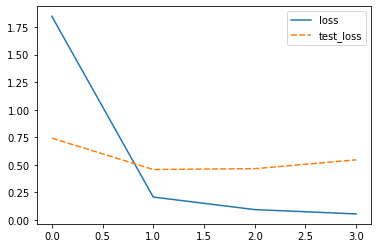

In [18]:
history = robust_model.fit(new_X_train, new_y_train, 
                    epochs=4, 
                    validation_data=(X_score, y_score), 
                    verbose=1)

history_df = pd.DataFrame({
    'loss': history.history['loss'],
    'test_loss': history.history['val_loss']
})

sns.lineplot(data=history_df)
plt.show()

Pruebas

In [19]:
Nclassifier = KerasClassifier(robust_model, clip_values=(0, 1), use_logits=False)

In [20]:
epsilon = 0.1  # Maximum perturbation
adv_crafter = FastGradientMethod(classifier, eps=epsilon)
x_test_adv = adv_crafter.generate(x=X_score)

In [23]:
# Evaluate the classifier on the adversarial examples
preds = np.argmax(Nclassifier.predict(x_test_adv), axis=1)
acc = np.sum(preds == np.argmax(y_score, axis=1)) / y_score.shape[0]
print("\nTest accuracy on adversarial sample: %.2f%%" % (acc * 100))


Test accuracy on adversarial sample: 83.40%


In [24]:
# Evaluate the classifier on clean data
preds_clean = np.argmax(classifier.predict(X_score), axis=1)
acc_clean = np.sum(preds_clean == np.argmax(y_score, axis=1)) / y_score.shape[0]
print("\nTest accuracy clean samples: %.2f%%" % (acc_clean * 100))


Test accuracy clean samples: 86.82%


In [31]:
y_pred = robust_model.predict(x_test_adv, verbose=0)


auc = roc_auc_score(y_score, y_pred)
print('ROC AUC on adversarial samples: %.2f%%' % (auc * 100))

ROC AUC on adversarial samples: 94.54%


In [33]:
y_pred_clean = robust_model.predict(X_score, verbose=0)


auc_clean = roc_auc_score(y_score, y_pred_clean)
print('ROC AUC on clean samples: %.2f%%' % (auc_clean * 100))

ROC AUC on clean samples: 94.46%
